In [1]:
library("limma")
library("edgeR")
library("matrixStats")
library("RColorBrewer")
library("sva")


suppressPackageStartupMessages(library("ggpubr"))
suppressPackageStartupMessages(library("proBatch"))

#suppressPackageStartupMessages(library("RRHO2"))

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: ‘genefilter’


The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars


Loading required package: BiocParallel



In [2]:
# from https://github.com/zhangyuqing/ComBat-seq
ComBat_seq <- function(counts, batch, group=NULL, covar_mod=NULL, full_mod=TRUE, 
                       shrink=FALSE, shrink.disp=FALSE, gene.subset.n=NULL){  
  ########  Preparation  ######## 
  counts <- as.matrix(counts)
  
  ## Does not support 1 sample per batch yet
  batch <- as.factor(batch)
  if(any(table(batch)<=1)){
    stop("ComBat-seq doesn't support 1 sample per batch yet")
  }
  
  ## Remove genes with only 0 counts in any batch
  keep_lst <- lapply(levels(batch), function(b){
    which(apply(counts[, batch==b], 1, function(x){!all(x==0)}))
  })
  keep <- Reduce(intersect, keep_lst)
  rm <- setdiff(1:nrow(counts), keep)
  countsOri <- counts
  counts <- counts[keep, ]
  
  # require bioconductor 3.7, edgeR 3.22.1
  dge_obj <- DGEList(counts=counts)
  
  ## Prepare characteristics on batches
  n_batch <- nlevels(batch)  # number of batches
  batches_ind <- lapply(1:n_batch, function(i){which(batch==levels(batch)[i])}) # list of samples in each batch  
  n_batches <- sapply(batches_ind, length)
  #if(any(n_batches==1)){mean_only=TRUE; cat("Note: one batch has only one sample, setting mean.only=TRUE\n")}
  n_sample <- sum(n_batches)
  cat("Found",n_batch,'batches\n')
  
  ## Make design matrix 
  # batch
  batchmod <- model.matrix(~-1+batch)  # colnames: levels(batch)
  # covariate
  group <- as.factor(group)
  if(full_mod & nlevels(group)>1){
    cat("Using full model in ComBat-seq.\n")
    mod <- model.matrix(~group)
  }else{
    cat("Using null model in ComBat-seq.\n")
    mod <- model.matrix(~1, data=as.data.frame(t(counts)))
  }
  # drop intercept in covariate model
  if(!is.null(covar_mod)){
    if(is.data.frame(covar_mod)){
      covar_mod <- do.call(cbind, lapply(1:ncol(covar_mod), function(i){model.matrix(~covar_mod[,i])}))
    }
    covar_mod <- covar_mod[, !apply(covar_mod, 2, function(x){all(x==1)})]
  }
  # bind with biological condition of interest
  mod <- cbind(mod, covar_mod)
  # combine
  design <- cbind(batchmod, mod)
  
  ## Check for intercept in covariates, and drop if present
  check <- apply(design, 2, function(x) all(x == 1))
  #if(!is.null(ref)){check[ref]=FALSE} ## except don't throw away the reference batch indicator
  design <- as.matrix(design[,!check])
  cat("Adjusting for",ncol(design)-ncol(batchmod),'covariate(s) or covariate level(s)\n')
  
  ## Check if the design is confounded
  if(qr(design)$rank<ncol(design)){
    #if(ncol(design)<=(n_batch)){stop("Batch variables are redundant! Remove one or more of the batch variables so they are no longer confounded")}
    if(ncol(design)==(n_batch+1)){stop("The covariate is confounded with batch! Remove the covariate and rerun ComBat-Seq")}
    if(ncol(design)>(n_batch+1)){
      if((qr(design[,-c(1:n_batch)])$rank<ncol(design[,-c(1:n_batch)]))){stop('The covariates are confounded! Please remove one or more of the covariates so the design is not confounded')
      }else{stop("At least one covariate is confounded with batch! Please remove confounded covariates and rerun ComBat-Seq")}}
  }
  
  ## Check for missing values in count matrix
  NAs = any(is.na(counts))
  if(NAs){cat(c('Found',sum(is.na(counts)),'Missing Data Values\n'),sep=' ')}
  
  
  ########  Estimate gene-wise dispersions within each batch  ########
  cat("Estimating dispersions\n")
  ## Estimate common dispersion within each batch as an initial value
  disp_common <- sapply(1:n_batch, function(i){
    if((n_batches[i] <= ncol(design)-ncol(batchmod)+1) | qr(mod[batches_ind[[i]], ])$rank < ncol(mod)){ 
      # not enough residual degree of freedom
      return(estimateGLMCommonDisp(counts[, batches_ind[[i]]], design=NULL, subset=nrow(counts)))
    }else{
      return(estimateGLMCommonDisp(counts[, batches_ind[[i]]], design=mod[batches_ind[[i]], ], subset=nrow(counts)))
    }
  })
  
  ## Estimate gene-wise dispersion within each batch 
  genewise_disp_lst <- lapply(1:n_batch, function(j){
    if((n_batches[j] <= ncol(design)-ncol(batchmod)+1) | qr(mod[batches_ind[[j]], ])$rank < ncol(mod)){
      # not enough residual degrees of freedom - use the common dispersion
      return(rep(disp_common[j], nrow(counts)))
    }else{
      return(estimateGLMTagwiseDisp(counts[, batches_ind[[j]]], design=mod[batches_ind[[j]], ], 
                                    dispersion=disp_common[j], prior.df=0))
    }
  })
  names(genewise_disp_lst) <- paste0('batch', levels(batch))
  
  ## construct dispersion matrix
  phi_matrix <- matrix(NA, nrow=nrow(counts), ncol=ncol(counts))
  for(k in 1:n_batch){
    phi_matrix[, batches_ind[[k]]] <- vec2mat(genewise_disp_lst[[k]], n_batches[k]) 
  }
  
  
  ########  Estimate parameters from NB GLM  ########
  cat("Fitting the GLM model\n")
  glm_f <- glmFit(dge_obj, design=design, dispersion=phi_matrix, prior.count=1e-4) #no intercept - nonEstimable; compute offset (library sizes) within function
  alpha_g <- glm_f$coefficients[, 1:n_batch] %*% as.matrix(n_batches/n_sample) #compute intercept as batch-size-weighted average from batches
  new_offset <- t(vec2mat(getOffset(dge_obj), nrow(counts))) +   # original offset - sample (library) size
    vec2mat(alpha_g, ncol(counts))  # new offset - gene background expression # getOffset(dge_obj) is the same as log(dge_obj$samples$lib.size)
  glm_f2 <- glmFit.default(dge_obj$counts, design=design, dispersion=phi_matrix, offset=new_offset, prior.count=1e-4) 
  
  gamma_hat <- glm_f2$coefficients[, 1:n_batch]
  mu_hat <- glm_f2$fitted.values
  phi_hat <- do.call(cbind, genewise_disp_lst)
  
  
  ########  In each batch, compute posterior estimation through Monte-Carlo integration  ########  
  if(shrink){
    cat("Apply shrinkage - computing posterior estimates for parameters\n")
    mcint_fun <- monte_carlo_int_NB
    monte_carlo_res <- lapply(1:n_batch, function(ii){
      if(ii==1){
        mcres <- mcint_fun(dat=counts[, batches_ind[[ii]]], mu=mu_hat[, batches_ind[[ii]]], 
                           gamma=gamma_hat[, ii], phi=phi_hat[, ii], gene.subset.n=gene.subset.n)
      }else{
        invisible(capture.output(mcres <- mcint_fun(dat=counts[, batches_ind[[ii]]], mu=mu_hat[, batches_ind[[ii]]], 
                                                    gamma=gamma_hat[, ii], phi=phi_hat[, ii], gene.subset.n=gene.subset.n)))
      }
      return(mcres)
    })
    names(monte_carlo_res) <- paste0('batch', levels(batch))
    
    gamma_star_mat <- lapply(monte_carlo_res, function(res){res$gamma_star})
    gamma_star_mat <- do.call(cbind, gamma_star_mat)
    phi_star_mat <- lapply(monte_carlo_res, function(res){res$phi_star})
    phi_star_mat <- do.call(cbind, phi_star_mat)
    
    if(!shrink.disp){
      cat("Apply shrinkage to mean only\n")
      phi_star_mat <- phi_hat
    }
  }else{
    cat("Shrinkage off - using GLM estimates for parameters\n")
    gamma_star_mat <- gamma_hat
    phi_star_mat <- phi_hat
  }
  
  
  ########  Obtain adjusted batch-free distribution  ########
  mu_star <- matrix(NA, nrow=nrow(counts), ncol=ncol(counts))
  for(jj in 1:n_batch){
    mu_star[, batches_ind[[jj]]] <- exp(log(mu_hat[, batches_ind[[jj]]])-vec2mat(gamma_star_mat[, jj], n_batches[jj]))
  }
  phi_star <- rowMeans(phi_star_mat)
  
  
  ########  Adjust the data  ########  
  cat("Adjusting the data\n")
  adjust_counts <- matrix(NA, nrow=nrow(counts), ncol=ncol(counts))
  for(kk in 1:n_batch){
    counts_sub <- counts[, batches_ind[[kk]]]
    old_mu <- mu_hat[, batches_ind[[kk]]]
    old_phi <- phi_hat[, kk]
    new_mu <- mu_star[, batches_ind[[kk]]]
    new_phi <- phi_star
    adjust_counts[, batches_ind[[kk]]] <- match_quantiles(counts_sub=counts_sub, 
                                                          old_mu=old_mu, old_phi=old_phi, 
                                                          new_mu=new_mu, new_phi=new_phi)
  }
  
  #dimnames(adjust_counts) <- dimnames(counts)
  #return(adjust_counts)
  
  ## Add back genes with only 0 counts in any batch (so that dimensions won't change)
  adjust_counts_whole <- matrix(NA, nrow=nrow(countsOri), ncol=ncol(countsOri))
  dimnames(adjust_counts_whole) <- dimnames(countsOri)
  adjust_counts_whole[keep, ] <- adjust_counts
  adjust_counts_whole[rm, ] <- countsOri[rm, ]
  return(adjust_counts_whole)
}
                 
####  Expand a vector into matrix (columns as the original vector)
vec2mat <- function(vec, n_times){
  return(matrix(rep(vec, n_times), ncol=n_times, byrow=FALSE))
}


####  Monte Carlo integration functions
monte_carlo_int_NB <- function(dat, mu, gamma, phi, gene.subset.n){
  weights <- pos_res <- list()
  for(i in 1:nrow(dat)){
    m <- mu[-i,!is.na(dat[i,])]
    x <- dat[i,!is.na(dat[i,])]
    gamma_sub <- gamma[-i]
    phi_sub <- phi[-i]
    
    # take a subset of genes to do integration - save time
    if(!is.null(gene.subset.n) & is.numeric(gene.subset.n) & length(gene.subset.n)==1){
      if(i==1){cat(sprintf("Using %s random genes for Monte Carlo integration\n", gene.subset.n))}
      mcint_ind <- sample(1:(nrow(dat)-1), gene.subset.n, replace=FALSE)
      m <- m[mcint_ind, ]; gamma_sub <- gamma_sub[mcint_ind]; phi_sub <- phi_sub[mcint_ind]
      G_sub <- gene.subset.n
    }else{
      if(i==1){cat("Using all genes for Monte Carlo integration; the function runs very slow for large number of genes\n")}
      G_sub <- nrow(dat)-1
    }
    
    #LH <- sapply(1:G_sub, function(j){sum(log2(dnbinom(x, mu=m[j,], size=1/phi_sub[j])+1))})  
    LH <- sapply(1:G_sub, function(j){prod(dnbinom(x, mu=m[j,], size=1/phi_sub[j]))})
    LH[is.nan(LH)]=0; 
    if(sum(LH)==0 | is.na(sum(LH))){
      pos_res[[i]] <- c(gamma.star=as.numeric(gamma[i]), phi.star=as.numeric(phi[i]))
    }else{
      pos_res[[i]] <- c(gamma.star=sum(gamma_sub*LH)/sum(LH), phi.star=sum(phi_sub*LH)/sum(LH))
    }
    
    weights[[i]] <- as.matrix(LH/sum(LH))
  }
  pos_res <- do.call(rbind, pos_res)
  weights <- do.call(cbind, weights)
  res <- list(gamma_star=pos_res[, "gamma.star"], phi_star=pos_res[, "phi.star"], weights=weights)	
  return(res)
} 


####  Match quantiles
match_quantiles <- function(counts_sub, old_mu, old_phi, new_mu, new_phi){
  new_counts_sub <- matrix(NA, nrow=nrow(counts_sub), ncol=ncol(counts_sub))
  for(a in 1:nrow(counts_sub)){
    for(b in 1:ncol(counts_sub)){
      if(counts_sub[a, b] <= 1){
        new_counts_sub[a,b] <- counts_sub[a, b]
      }else{
        tmp_p <- pnbinom(counts_sub[a, b]-1, mu=old_mu[a, b], size=1/old_phi[a])
        if(abs(tmp_p-1)<1e-4){
          new_counts_sub[a,b] <- counts_sub[a, b]  
          # for outlier count, if p==1, will return Inf values -> use original count instead
        }else{
          new_counts_sub[a,b] <- 1+qnbinom(tmp_p, mu=new_mu[a, b], size=1/new_phi[a])
        }
      }
    }
  }
  return(new_counts_sub)
}



mapDisp <- function(old_mu, new_mu, old_phi, divider){
  new_phi <- matrix(NA, nrow=nrow(old_mu), ncol=ncol(old_mu))
  for(a in 1:nrow(old_mu)){
    for(b in 1:ncol(old_mu)){
      old_var <- old_mu[a, b] + old_mu[a, b]^2 * old_phi[a, b]
      new_var <- old_var / (divider[a, b]^2)
      new_phi[a, b] <- (new_var - new_mu[a, b]) / (new_mu[a, b]^2)
    }
  }
  return(new_phi)
}

In [3]:
count_matrix <- matrix(rnbinom(400, size=10, prob=0.1), nrow=50, ncol=8)
batch <- c(rep(1, 4), rep(2, 4))
group <- rep(c(0,1), 4)

# include condition (group variable)
adjusted_counts <- ComBat_seq(count_matrix, batch=batch, group=group, full_mod=TRUE)



Found 2 batches
Using full model in ComBat-seq.
Adjusting for 1 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


In [4]:
counts_file <- "new_datasets_subt/four_gse.counts.tsv"
design_file  <- "new_datasets_subt/four_gse.sample_info.tsv"
outfile_basename  <- "tmp"
group1 <- "Lum" 
group2 <- "Basal"

In [5]:
# read inputs
counts <- read.delim(counts_file, row.names = 1)
colnames(counts) <- gsub("\\.", "-",colnames(counts))
covars <- c(group1,group2,"is_LumA","series_id","subtype") # "diagnosis_age","stage","is_LumA"
design_m <- read.delim(design_file, row.names = 1)
design_m <-design_m[design_m$series_id!="GSE119937",] # exclude "GSE119937"
counts <- counts[,rownames(design_m)]

batch <- as.numeric(as.factor(design_m$series_id))-1
head(design_m ,3)

design_m <- design_m[,covars]
group <- design_m[,group1]


,Lum,Basal,is_LumA,series_id,instrument_model,library_selection,subtype
GSM3714577,1,0,1,GSE129508,NextSeq 500,cDNA,LumA
GSM3714579,1,0,0,GSE129508,NextSeq 500,cDNA,LumB
GSM3714581,1,0,0,GSE129508,NextSeq 500,cDNA,LumB


In [6]:
adjusted_counts <- ComBat_seq(counts, batch=batch, group=group, full_mod=TRUE)
head(adjusted_counts,3)

Found 3 batches
Using full model in ComBat-seq.
Adjusting for 1 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,...,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
A1BG,512,1045,926,538,1301,136,532,121,715,259,...,1619,175,629,620,2051,836,295,2042,776,400
A1CF,18,41,0,21,42,0,12,16,10,29,...,52,2,11,13,103,33,7,34,9,13
A2M,11644,11833,9203,10418,30654,3802,9258,29357,20242,12231,...,9204,20215,22653,25205,4962,8416,62137,26992,5957,250336


In [7]:
counts <- adjusted_counts
raw_exprs <- DGEList(counts)


# normalize 
all_groups <- c(group1,group2)
group = as.factor(apply(design_m[,all_groups], 1, function(x) {
  all_groups[as.logical(x)]
}))
exprs <- raw_exprs
keep_exprs <- filterByExpr(exprs, group=group)

cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
exprs <- exprs[keep_exprs,, keep.lib.sizes=FALSE]

exprs <- calcNormFactors(exprs, method = "upperquartile") # TMM

lcpm_combatseq <- cpm(exprs, log=TRUE)
#write.table(lcpm,"norm_lcpm.tsv",row.names=TRUE, quote = FALSE,dec = ".", sep="\t")
head(lcpm_combatseq,3)

Genes passed filterByExprs: 18947

,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,...,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
A1BG,4.0628975,5.2897334,5.009926,4.69199049,5.2839330,2.595744,4.5122729,1.726730,4.393526,3.5550770,...,6.154841,1.779980,4.040249,4.116828,6.086061,5.2632317,2.313194,5.5565391,4.510862,2.914429
A1CF,-0.6203999,0.6757283,-3.938596,0.09978737,0.4014799,-3.938596,-0.7896118,-1.016690,-1.480930,0.4583794,...,1.233648,-3.269229,-1.507163,-1.225560,1.796409,0.6586822,-2.461180,-0.2382784,-1.604385,-1.698412
A2M,8.5648044,8.7887799,8.320317,8.96386263,9.8400012,7.385738,8.6295840,9.620691,9.212466,9.1086668,...,8.660910,8.604488,9.205176,9.456826,7.359843,8.5925833,10.012821,9.2791670,7.447726,12.191565


In [8]:
design_m["FullRunName"] <- rownames(design_m)
suppressWarnings(color_list <-sample_annotation_to_colors(design_m,
                                         factor_columns =c('series_id','subtype'),
                                         numeric_columns = NULL))

converting columns to corresponding classes 
          (factor, numeric)



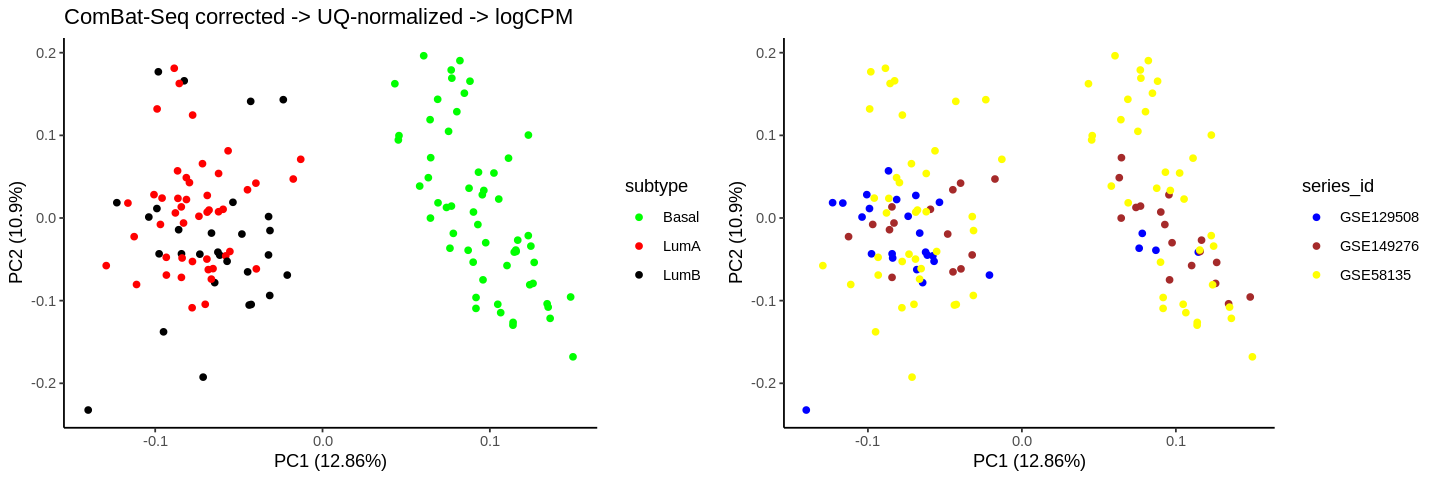

In [9]:
options(repr.plot.width=12, repr.plot.height=4)
x <- lcpm_combatseq
a <- design_m[colnames(lcpm_combatseq),]
method <- "ComBat-Seq corrected -> UQ-normalized -> logCPM"
b <- 'series_id'
pca1_combat = proBatch::plot_PCA(x, a,
               color_by =b,
               plot_title ="", color_scheme = color_list[[b]])
b <- 'subtype'
pca2_combat = proBatch::plot_PCA(x, a,
               color_by =b,
               plot_title = method, color_scheme = color_list[[b]])
ggarrange(pca2_combat, pca1_combat, ncol = 2, nrow = 1)

### limma

In [10]:
run_limma <- function(exprs, design_m, group1, group2){
    # assumes thant norm.factors are included to the  
    voom_results <-  voom(exprs, design_m, plot = F, save.plot=F)

    ### lmFit limma ### 
    fit <- lmFit(voom_results, design_m)
    contrasts_matrix <- makeContrasts(contrasts = paste0(group1,"-",group2), levels = colnames(fit$coefficients))
    #contrasts_matrix <- makeContrasts(sun_exposed - not_sun_exposed, levels = colnames(fit$coefficients))

    contr_fit <- contrasts.fit(fit, contrasts_matrix)
    result <- eBayes(contr_fit)

    ### plot ###
    #plotSA(result, main="Final model: Mean-variance trend")
    #dev.off()

    table_res <- topTable(result, adjust="BH",resort.by="P",p.value=1,confint=TRUE,number=dim(exprs$counts)[1])
    table_res
}

In [11]:
design_m <- design_m[,c("Lum","Basal","is_LumA")]
head(design_m,3)

,Lum,Basal,is_LumA
GSM3714577,1,0,1
GSM3714579,1,0,0
GSM3714581,1,0,0


In [12]:
table_res_combatseq <- run_limma(exprs, as.matrix(design_m),"Lum","Basal")
table_res_combatseq$rank <- c(1:dim(table_res_combatseq)[[1]]+1)-1
table_res_combatseq

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,rank
FOXA1,6.777252,6.203502,7.351001,5.4532419,23.36168,3.455513e-49,6.547161e-45,100.59191,1
ESR1,5.962278,5.396642,6.527914,5.6438579,20.84720,5.764054e-44,5.460577e-40,89.14358,2
RAD17P1,7.376862,6.641450,8.112275,-0.8345790,19.83870,8.947432e-42,5.650900e-38,81.34709,3
SPDEF,6.075785,5.454787,6.696783,5.1321521,19.35017,1.079265e-40,4.729494e-37,81.63982,4
AGR3,8.798021,7.897468,9.698574,2.8040112,19.32184,1.248085e-40,4.729494e-37,80.48897,5
TBC1D9,3.950533,3.538999,4.362067,6.7542092,18.98553,7.060282e-40,2.076315e-36,80.12854,6
AGR2,7.890371,7.067723,8.713019,4.4783924,18.96950,7.670978e-40,2.076315e-36,79.45206,7
XBP1,3.461207,3.082037,3.840377,8.7201593,18.05370,9.252763e-38,2.191401e-34,75.29460,8
GATA3,4.202866,3.733390,4.672342,7.9729709,17.70537,5.885840e-37,1.239100e-33,73.47670,9
MLPH,4.835097,4.292308,5.377886,7.0515710,17.61759,9.403894e-37,1.781756e-33,73.00722,10


# Limma without any correction

In [13]:
# read inputs
counts <- read.delim(counts_file, row.names = 1)
colnames(counts) <- gsub("\\.", "-",colnames(counts))
covars <- c(group1,group2,"is_LumA") # "diagnosis_age","stage","is_LumA"
design_m <- read.delim(design_file, row.names = 1)

design_m <-design_m[design_m$series_id!="GSE119937",] # exclude "GSE119937"
counts <- counts[,rownames(design_m)]
a <- design_m[colnames(counts),]

design_m <- design_m[,covars]
print(head(design_m,3))

raw_exprs <- DGEList(counts)
all_groups <- c(group1,group2)

# filter and normalize
exprs <- raw_exprs 
group = as.factor(apply(design_m[all_groups], 1, function(x) {
  all_groups[as.logical(x)]
}))
keep_exprs <- filterByExpr(exprs, group=group)
cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
exprs <- exprs[keep_exprs,, keep.lib.sizes=FALSE]
exprs <- calcNormFactors(exprs, method = "upperquartile") # TMM
lcpm <- cpm(exprs, log=TRUE)

dim(design_m)
dim(exprs$counts)

           Lum Basal is_LumA
GSM3714577   1     0       1
GSM3714579   1     0       0
GSM3714581   1     0       0
Genes passed filterByExprs: 19861

[1] 132   3

[1] 19861   132

png 
  2

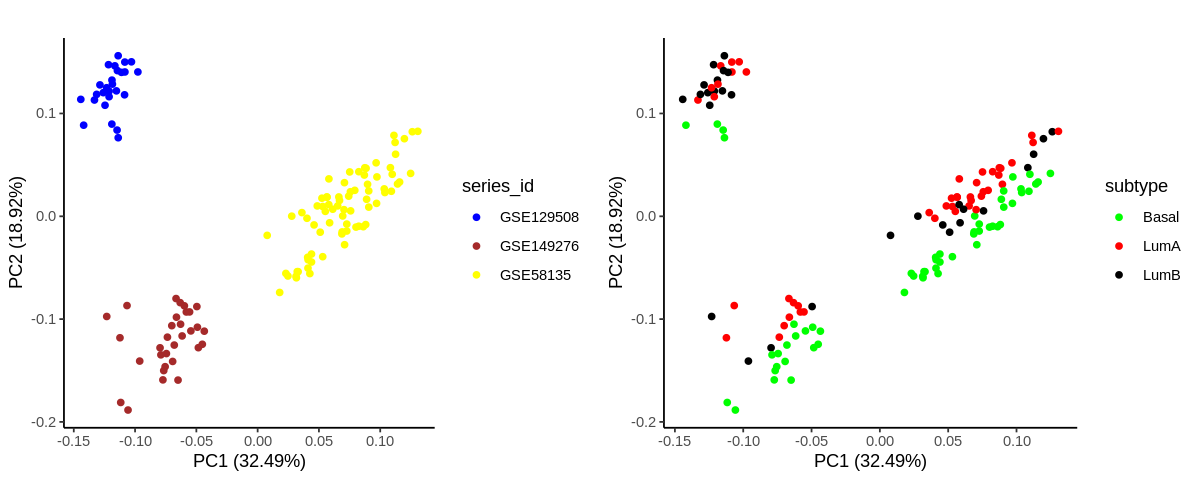

In [14]:
png("GEO_datasets.png", width = 1200, height = 500, res = 150, pointsize=24)
#options(repr.plot.width=12, repr.plot.height=4)
x <- lcpm

a["FullRunName"] <- rownames(a)
method <- "logCPM, UQ-normalized"
b <- 'series_id'
pca1 = proBatch::plot_PCA(x, a,
               color_by =b,
               plot_title = "", color_scheme = color_list[[b]])
b <- 'subtype'
pca2 = proBatch::plot_PCA(x, a,
               color_by =b,
               plot_title = "", color_scheme = color_list[[b]])
ggarrange(pca1, pca2, ncol = 2, nrow = 1)
dev.off()

options(repr.plot.width=10, repr.plot.height=4)
ggarrange(pca1, pca2, ncol = 2, nrow = 1)

In [39]:
table_res_nc <- run_limma(exprs, as.matrix(design_m),"Lum","Basal")
table_res_nc$rank <- c(1:dim(table_res_nc)[[1]]+1)-1
table_res_nc

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,rank
ESR1,6.563194,5.950775,7.175612,5.2526557,21.19548,1.088656e-44,2.162179e-40,90.70318,1
FOXA1,7.468671,6.762117,8.175226,5.0080777,20.90615,4.505953e-44,4.474637e-40,89.16103,2
AGR3,9.014607,8.138525,9.890689,2.3497638,20.35066,7.096146e-43,4.697885e-39,86.01877,3
RAD17P1,7.398817,6.569308,8.228327,-1.1213546,17.64076,8.586323e-37,4.263324e-33,71.86820,4
TBC1D9,4.596039,4.061547,5.130531,6.4116873,17.00665,2.595363e-35,1.030930e-31,69.71255,5
SLC44A4,5.542327,4.882831,6.201822,3.8258537,16.62099,2.112182e-34,6.991673e-31,67.45661,6
AGR2,8.145478,7.162403,9.128553,3.9938388,16.38726,7.589394e-34,2.153328e-30,66.13214,7
THSD4,4.203959,3.686927,4.720990,5.3655466,16.08117,4.090075e-33,1.015412e-29,64.71001,8
MLPH,5.021504,4.378307,5.664701,6.6918222,15.44067,1.435217e-31,3.167206e-28,61.20098,9
ZNF552,3.292342,2.864642,3.720043,5.3589536,15.22445,4.817255e-31,9.567550e-28,60.02118,10


# let's compare the results of limma with ds

In [20]:
design_m_ds <- read.delim("new_datasets_subt/four_gse.sample_info.tsv", row.names = 1)
design_m_ds <- design_m_ds[,c("Lum","Basal","is_LumA","series_id")]
design_m_ds <-design_m_ds[design_m_ds$series_id!="GSE119937",]
dim(design_m_ds)
datasets <- c("GSE129508","GSE149276","GSE58135") #unique(design_m$series_id)
for (gse in head(datasets,length(datasets)-1)){
    print(gse)
    design_m_ds[,gse] <- 0
    design_m_ds[design_m_ds$series_id==gse,gse] <-1
}
design_m_ds <- design_m_ds[,c("Lum","Basal","is_LumA","GSE129508","GSE149276")]
head(design_m_ds,3)

[1] 132   4

[1] "GSE129508"
[1] "GSE149276"


,Lum,Basal,is_LumA,GSE129508,GSE149276
GSM3714577,1,0,1,1,0
GSM3714579,1,0,0,1,0
GSM3714581,1,0,0,1,0


In [21]:
### read inputs again 
counts <- read.delim("new_datasets_subt/four_gse.counts.tsv", row.names = 1)
counts <- counts[,rownames(design_m_ds)]
head(counts )

design_m_ds <- mapply(as.numeric,design_m_ds)
raw_exprs <- DGEList(counts)
head(raw_exprs$counts,3)
head(raw_exprs$samples,3)
# normalize 
all_groups <- c(group1,group2)
group = as.factor(apply(design_m_ds[,all_groups], 1, function(x) {
  all_groups[as.logical(x)]
}))

exprs <- raw_exprs
keep_exprs <- filterByExpr(exprs, group=group)
cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
exprs <- exprs[keep_exprs,, keep.lib.sizes=FALSE]
exprs_ds <- calcNormFactors(exprs, method = "upperquartile") # TMM


,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,...,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
A1BG,363,732,650,379,912,98,376,88,506,184,...,1914,425,1051,1034,2422,1147,634,2498,1179,760
A1CF,5,16,0,7,15,0,3,4,2,10,...,110,9,33,38,205,76,26,83,26,41
A2M,19059,16821,15554,14844,31897,10656,15895,32102,26985,20846,...,5048,11582,16842,19400,1912,4247,48515,18468,2978,256904
A2ML1,52,31,11,44,101,64,121,62,51,1300,...,1218,4266,219,141,248,933,9083,793,121,291
A2MP1,1,0,0,0,1,0,0,0,1,0,...,39,8,34,74,19,14,21,19,6,67
A3GALT2,1,0,2,1,7,0,1,1,3,2,...,43,9,6,11,23,63,9,34,6,12


,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,...,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
A1BG,363,732,650,379,912,98,376,88,506,184,...,1914,425,1051,1034,2422,1147,634,2498,1179,760
A1CF,5,16,0,7,15,0,3,4,2,10,...,110,9,33,38,205,76,26,83,26,41
A2M,19059,16821,15554,14844,31897,10656,15895,32102,26985,20846,...,5048,11582,16842,19400,1912,4247,48515,18468,2978,256904


,group,lib.size,norm.factors
GSM3714577,1,37902508,1
GSM3714579,1,29543268,1
GSM3714581,1,31781742,1


Genes passed filterByExprs: 19861

In [22]:
#table_res_ds <- run_limma(exprs_ds, as.matrix(design_m_ds),"Lum","Basal")
#table_res_ds$rank <- c(1:dim(table_res_ds)[[1]]+1)-1
#table_res_ds

In [23]:
table_res_ds <-  read.delim("web_Flimma_results.csv", row.names = 1)
table_res_ds$rank <- c(1:dim(table_res_ds)[[1]]+1)-1
table_res_ds

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,lods,rank
AGR3,8.924335,8.184602,9.664068,2.3497638,23.86321,7.652870e-50,1.519936e-45,102.11833,1
FOXA1,6.592591,6.009248,7.175934,5.0080777,22.35425,7.998277e-47,7.942689e-43,95.54130,2
ESR1,6.031202,5.445715,6.616688,5.2526557,20.37580,1.111366e-42,7.357615e-39,86.31273,3
AGR2,8.142404,7.346430,8.938377,3.9938388,20.23401,2.243717e-42,1.114062e-38,85.51691,4
RAD17P1,7.252850,6.495798,8.009902,-1.1213546,18.95008,1.458739e-39,5.794404e-36,78.16880,5
TBC1D9,3.956901,3.528155,4.385647,6.4116873,18.25505,5.301775e-38,1.754976e-34,75.86698,6
SPDEF,5.889461,5.208433,6.570490,4.7821397,17.10560,2.302352e-35,6.532430e-32,69.76279,7
SLC44A4,5.249980,4.628335,5.871624,3.8258537,16.70488,1.986353e-34,4.931371e-31,67.61036,8
PRR15,4.797367,4.215266,5.379468,1.5956577,16.30168,1.770028e-33,3.906059e-30,65.39906,9
MLPH,4.863655,4.256392,5.470918,6.6918222,15.84215,2.189932e-32,4.349424e-29,63.05525,10


# limma+ PCA 

In [42]:
design_m_pca <- read.delim("new_datasets_subt/four_gse.sample_info.tsv", row.names = 1)
design_m_pca <-design_m_pca[design_m_pca$series_id!="GSE119937",] # exclude "GSE119937"
design_m_pca <- design_m_pca[,c("Lum","Basal","is_LumA",'series_id',"subtype")]
dim(design_m_pca)
head(design_m_pca,3)
 
# read counts
counts <- read.delim("new_datasets_subt/four_gse.counts.tsv", row.names = 1)
counts <- counts[,rownames(design_m_pca)]


design_m_ds <- mapply(as.numeric,design_m_ds)

raw_exprs <- DGEList(counts)
# normalize 
all_groups <- c(group1,group2)
group = as.factor(apply(design_m_pca[,all_groups], 1, function(x) {
  all_groups[as.logical(x)]
}))


exprs <- raw_exprs 
keep_exprs <- filterByExpr(exprs, group=group)
cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
exprs <- exprs[keep_exprs,, keep.lib.sizes=FALSE]
exprs_pca <- calcNormFactors(exprs, method = "upperquartile") # TMM
counts_pca <- counts[rownames(exprs_pca), colnames(exprs_pca)] 
lcpm_pca <- cpm(exprs_pca, log=TRUE)
dim(counts_pca)
head(counts,3)

[1] 132   5

,Lum,Basal,is_LumA,series_id,subtype
GSM3714577,1,0,1,GSE129508,LumA
GSM3714579,1,0,0,GSE129508,LumB
GSM3714581,1,0,0,GSE129508,LumB


Genes passed filterByExprs: 19861

[1] 19861   132

,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,...,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
A1BG,363,732,650,379,912,98,376,88,506,184,...,1914,425,1051,1034,2422,1147,634,2498,1179,760
A1CF,5,16,0,7,15,0,3,4,2,10,...,110,9,33,38,205,76,26,83,26,41
A2M,19059,16821,15554,14844,31897,10656,15895,32102,26985,20846,...,5048,11582,16842,19400,1912,4247,48515,18468,2978,256904


In [43]:
n <-1
components <- paste0(rep("PC",n),c(1:n))
pca_cov <- pca1$data[components]
d <- cbind(design_m_pca[c("Lum","Basal","is_LumA")],pca_cov )
head(d)

,Lum,Basal,is_LumA,PC1
GSM3714577,1,0,1,-0.10828385
GSM3714579,1,0,0,-0.11523247
GSM3714581,1,0,0,-0.11109003
GSM3714585,1,0,1,-0.10834949
GSM3714587,1,0,1,-0.09770167
GSM3714589,1,0,0,-0.12865637


In [44]:
table_res_pca <- run_limma(exprs_pca, as.matrix(d),"Lum","Basal")
table_res_pca$rank <- c(1:dim(table_res_pca)[[1]]+1)-1
table_res_pca

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,rank
FOXA1,6.966398,6.337644,7.595152,5.0080777,21.91543,5.939877e-46,1.179719e-41,93.48506,1
AGR3,8.619305,7.827855,9.410755,2.3497638,21.54127,3.553793e-45,3.529094e-41,91.41903,2
ESR1,6.208889,5.628206,6.789571,5.2526557,21.14939,2.357999e-44,1.561074e-40,90.02491,3
RAD17P1,7.772947,7.035334,8.510560,-1.1213546,20.84393,1.044553e-43,5.186468e-40,87.43150,4
TBC1D9,4.054374,3.638327,4.470421,6.4116873,19.27543,2.622205e-40,1.041592e-36,81.08334,5
AGR2,7.485778,6.641721,8.329834,3.9938388,17.54235,2.145791e-36,6.523183e-33,71.96679,6
SPDEF,5.928413,5.259428,6.597397,4.7821397,17.52850,2.309438e-36,6.523183e-33,72.01780,7
MLPH,5.416909,4.804796,6.029023,6.6918222,17.50419,2.627535e-36,6.523183e-33,71.96858,8
SLC44A4,5.609539,4.939340,6.279738,3.8258537,16.55563,4.273975e-34,9.431712e-31,66.83600,9
THSD4,4.176966,3.643512,4.710421,5.3655466,15.48766,1.494380e-31,2.870806e-28,61.17610,10


# TCGA 

In [15]:
# read inputs
counts <- read.delim("../evaluation/TCGA-BRCA/TCGA-BRCA.counts.tsv", row.names = 1)
colnames(counts) <- gsub("\\.", "-",colnames(counts))
covars <- c(group1,group2,"is_LumA","cohort") # "diagnosis_age","stage","is_LumA"
design_m <- read.delim("../evaluation/TCGA-BRCA/TCGA.annotation_v3.tsv", row.names = 1)
design_m_tcga <- design_m[,covars]
design_m_tcga$subtype <- "LumB"
design_m_tcga[design_m_tcga$is_LumA==1,"subtype"] <- "LumA"
design_m_tcga[design_m_tcga$Basal==1,"subtype"] <- "Basal"
counts <- counts[,rownames(design_m_tcga)]
all_groups <- c(group1,group2)
dim(design_m_tcga[[1]])
head(design_m_tcga,5)

raw_exprs <- DGEList(counts)

NULL

,Lum,Basal,is_LumA,cohort,subtype
TCGA-3C-AALJ-01,1,0,0,3C,LumB
TCGA-3C-AALK-01,1,0,1,3C,LumA
TCGA-4H-AAAK-01,1,0,1,4H,LumA
TCGA-5L-AAT0-01,1,0,1,5L,LumA
TCGA-5T-A9QA-01,1,0,0,5T,LumB


In [16]:
# filter and normalize
exprs <- raw_exprs 
group = as.factor(apply(design_m_tcga[all_groups], 1, function(x) {
  all_groups[as.logical(x)]
}))
keep_exprs <- filterByExpr(exprs, group=group)
cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
exprs <- exprs[keep_exprs,, keep.lib.sizes=FALSE]
exprs_tcga <- calcNormFactors(exprs, method = "upperquartile") # TMM
lcpm_tcga <- cpm(exprs, log=TRUE)
#write.table(lcpm,"TCGA-BRCA.norm_lcpm.tsv",row.names=TRUE, quote = FALSE,dec = ".", sep="\t")

Genes passed filterByExprs: 16927

In [58]:
#?proBatch::plot_PCA

In [ ]:
#png("TCGA-BRCA.png", width = 1200, height = 500, res = 150, pointsize=24)
x <- lcpm_tcga
a <- design_m_tcga[colnames(x),]
a["FullRunName"] <- rownames(a)
method <- ""
b <- 'cohort'
pca1_tcga = proBatch::plot_PCA(x, a,
               color_by =b,
               plot_title ="", color_scheme = color_list[[b]])
b <- 'subtype'
pca2_tcga = proBatch::plot_PCA(x, a,
               color_by =b,
               plot_title ="", color_scheme = color_list[[b]])
#ggarrange(pca1_tcga, pca2_tcga, ncol = 2, nrow = 1)
#dev.off()

options(repr.plot.width=10, repr.plot.height=4)
ggarrange(pca1_tcga, pca2_tcga, ncol = 2, nrow = 1)

Warning message in color_by_factor(color_by_batch = TRUE, batch_col = color_by, :
“color_scheme will be inferred automatically.
              Numeric/factor columns are guessed, for more controlled color 
              mapping use sample_annotation_to_colors()”
Warning message in add_color_scheme_discrete(color_scheme, n_batches, fill_or_color, :
“brewer palettes have maximally 12 colors, 
                        37 batches are specified,
                        consider defining color scheme with 
                        sample_annotation_to_colors function”


In [30]:
covars <- c(group1,group2,"is_LumA")
design_m_tcga <- design_m[,covars]

table_res_tcga <- run_limma(exprs_tcga,design_m_tcga,"Lum","Basal")
table_res_tcga$rank <- c(1:dim(table_res_tcga)[[1]]+1)-1
table_res_tcga

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,rank
FOXA1,6.505065,6.271752,6.738379,7.32634277,54.72399,4.528955e-281,7.666162e-277,633.0156,1
FOXC1,-4.841831,-5.070962,-4.612701,3.29983045,-41.47555,1.340659e-206,1.134667e-202,462.2079,2
MLPH,5.117475,4.871570,5.363380,7.45474156,40.84641,7.796654e-203,4.399132e-199,453.6591,3
GATA3,4.391977,4.171343,4.612612,8.54355477,39.07080,4.140430e-192,1.752126e-188,429.0491,4
ESR1,7.002749,6.647830,7.357669,7.78089000,38.72620,5.189272e-190,1.756776e-186,424.1267,5
XBP1,3.154769,2.994064,3.315474,10.54806329,38.53041,8.117701e-189,2.290139e-185,421.4723,6
SPDEF,5.363780,5.067474,5.660087,6.55665728,35.53004,2.552779e-170,6.172985e-167,378.8999,7
SFRS13B,-4.394370,-4.639703,-4.149037,-0.93439496,-35.15655,5.407868e-168,1.144237e-164,372.7977,8
B3GNT5,-3.349093,-3.537431,-3.160755,2.92818469,-34.90241,2.081505e-166,3.914848e-163,369.9201,9
CA12,4.914322,4.632137,5.196508,7.98214813,34.18174,6.683080e-162,1.131245e-158,359.5944,10


# Compare DE genes in TCGA-BRCA with DE genes in three other datasets

In [57]:
shared_genes <- intersect(rownames(table_res_tcga), rownames(table_res_ds))
length(shared_genes)
head(shared_genes,20)

[1] 14345

[1] "FOXA1"    "FOXC1"    "MLPH"     "GATA3"    "ESR1"     "XBP1"    
 [7] "SPDEF"    "B3GNT5"   "CA12"     "TBC1D9"   "BCL11A"   "FAM171A1"
[13] "CT62"     "CHODL"    "RGMA"     "PSAT1"    "CMBL"     "ROPN1"   
[19] "MICALL1"  "LEMD1"

In [58]:
res_tcga <- table_res_tcga[shared_genes,]["rank"]
colnames(res_tcga) <- "TCGA"
res_ds <- table_res_ds[shared_genes,]["rank"]
colnames(res_ds) <- "Flimma+ds"
res_nc <- table_res_nc[shared_genes,]["rank"]
colnames(res_nc) <- "limma (no correction)"
res_combat <- table_res_combatseq[shared_genes,]["rank"]
colnames(res_combat) <- "limma+ComBat"
res<- cbind(res_tcga,res_ds,res_nc,res_combat)
res


,TCGA,Flimma+ds,limma (no correction),limma+ComBat
FOXA1,1,2,2,1
FOXC1,2,12,24,16
MLPH,3,10,9,10
GATA3,4,13,11,9
ESR1,5,3,1,2
XBP1,6,14,69,8
SPDEF,7,7,61,4
B3GNT5,9,34,65,26
CA12,10,27,19,20
TBC1D9,11,6,5,6


In [59]:
# try with 2-4 PC as covatriates:
for (n in c(1,2,3,4)){
    print(cat("PC used:"," ",n))
    components <- paste0(rep("PC",n),c(1:n))
    pca_cov <- pca1$data[components]
    d <- cbind(design_m_pca[c("Lum","Basal","is_LumA")],pca_cov )
    table_res_pca <- run_limma(exprs_pca, as.matrix(d),"Lum","Basal")
    table_res_pca$rank <- c(1:dim(table_res_pca)[[1]]+1)-1
    res_pca <- table_res_pca[shared_genes,]["rank"]
    colnames(res_pca) <- paste0("limma+",n,"PC")
    res<- cbind(res,res_pca)  
}
write.table(res,"gene_ranks.tsv",row.names=TRUE, quote = FALSE,dec = ".", sep="\t")
res

PC used:   1NULL
PC used:   2NULL
PC used:   3NULL
PC used:   4NULL


,TCGA,Flimma+ds,limma (no correction),limma+ComBat,limma+1PC,limma+2PC,limma+3PC,limma+4PC
FOXA1,1,2,2,1,1,3,147,301
FOXC1,2,12,24,16,20,14,508,261
MLPH,3,10,9,10,8,9,1725,1438
GATA3,4,13,11,9,11,16,2116,998
ESR1,5,3,1,2,3,5,79,719
XBP1,6,14,69,8,134,6,1797,3209
SPDEF,7,7,61,4,7,8,2660,3263
B3GNT5,9,34,65,26,72,107,8881,8841
CA12,10,27,19,20,17,28,3126,3462
TBC1D9,11,6,5,6,5,7,1177,2329


In [60]:
# ComBat + limma 
# spearman correlation
method <- "spearman"
rho <- cor.test(res$"limma+ComBat",res$"Flimma+ds", method=c(method))
print(cat("limma+ComBat vs Flimma+ds", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"limma+ComBat",res$"limma (no correction)", method=c(method))
print(cat("limma+ComBat vs limma (no correction)", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <-  cor.test(res$"limma+ComBat",res$"TCGA", method=c(method))
print(cat("limma+ComBat vs TCGA", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"limma+ComBat",res$"limma+1PC", method=c(method))
print(cat("limma+ComBat vs limma+1PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"limma+ComBat",res$"limma+2PC", method=c(method))
print(cat("limma+ComBat vs limma+2PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <-  cor.test(res$"limma+ComBat",res$"limma+3PC", method=c(method))
print(cat("limma+ComBat vs limma+3PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value) ))

rho <-  cor.test(res$"limma+ComBat",res$"limma+4PC", method=c(method))
print(cat("limma+ComBat vs limma+4PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

Warning message in cor.test.default(res$"limma+ComBat", res$"Flimma+ds", method = c(method)):
“Cannot compute exact p-value with ties”

limma+ComBat vs Flimma+ds 0.9623037 p-val< 2.2e-16NULL


Warning message in cor.test.default(res$"limma+ComBat", res$"limma (no correction)", :
“Cannot compute exact p-value with ties”

limma+ComBat vs limma (no correction) 0.493839 p-val< 2.2e-16NULL


Warning message in cor.test.default(res$"limma+ComBat", res$TCGA, method = c(method)):
“Cannot compute exact p-value with ties”

limma+ComBat vs TCGA 0.6658621 p-val< 2.2e-16NULL


Warning message in cor.test.default(res$"limma+ComBat", res$"limma+1PC", method = c(method)):
“Cannot compute exact p-value with ties”

limma+ComBat vs limma+1PC 0.6692824 p-val< 2.2e-16NULL


Warning message in cor.test.default(res$"limma+ComBat", res$"limma+2PC", method = c(method)):
“Cannot compute exact p-value with ties”

limma+ComBat vs limma+2PC 0.7092579 p-val< 2.2e-16NULL


Warning message in cor.test.default(res$"limma+ComBat", res$"limma+3PC", method = c(method)):
“Cannot compute exact p-value with ties”

limma+ComBat vs limma+3PC -0.01794226 p-val< 0.03199756NULL


Warning message in cor.test.default(res$"limma+ComBat", res$"limma+4PC", method = c(method)):
“Cannot compute exact p-value with ties”

limma+ComBat vs limma+4PC -0.004167906 p-val< 0.6184093NULL


In [61]:
# TCGA
method <- "spearman"
rho <- cor.test(res$"TCGA",res$"Flimma+ds", method=c(method))
print(cat("TCGA vs Flimma+ds", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"TCGA",res$"limma+ComBat", method=c(method))
print(cat("TCGA vs limma+ComBat", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"TCGA",res$"limma (no correction)", method=c(method))
print(cat("TCGA vs limma (no correction)", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"TCGA",res$"limma+1PC", method=c(method))
print(cat("TCGA vs limma+1PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"TCGA",res$"limma+2PC", method=c(method))
print(cat("TCGA vs limma+2PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <-  cor.test(res$"TCGA",res$"limma+3PC", method=c(method))
print(cat("TCGA vs limma+3PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value) ))

rho <-  cor.test(res$"TCGA",res$"limma+4PC", method=c(method))
print(cat("TCGA vs limma+4PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))


TCGA vs Flimma+ds 0.67249 p-val< 2.2e-16NULL


Warning message in cor.test.default(res$TCGA, res$"limma+ComBat", method = c(method)):
“Cannot compute exact p-value with ties”

TCGA vs limma+ComBat 0.6658621 p-val< 2.2e-16NULL
TCGA vs limma (no correction) 0.4777429 p-val< 2.2e-16NULL
TCGA vs limma+1PC 0.4923945 p-val< 2.2e-16NULL
TCGA vs limma+2PC 0.4980048 p-val< 2.2e-16NULL
TCGA vs limma+3PC 0.02248361 p-val< 0.007081612NULL
TCGA vs limma+4PC 0.02590078 p-val< 0.001919565NULL


In [108]:
method <- "pearson"
rho <- cor.test(res$"TCGA",res$"Flimma+ds", method=c(method))
print(cat("TCGA vs Flimma+ds", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"TCGA",res$"limma+1PC", method=c(method))
print(cat("TCGA vs limma+1PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"TCGA",res$"limma+2PC", method=c(method))
print(cat("TCGA vs limma+2PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <-  cor.test(res$"TCGA",res$"limma+3PC", method=c(method))
print(cat("TCGA vs limma+3PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value) ))

rho <-  cor.test(res$"TCGA",res$"limma+4PC", method=c(method))
print(cat("TCGA vs limma+4PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

print(cat("Flimma+ds vs limma+1PC", cor(res$"Flimma+ds",res$"limma+1PC", method=c(method))))

TCGA vs Flimma+ds 0.6619114 p-val< 2.2e-16NULL
TCGA vs limma+1PC 0.4846518 p-val< 2.2e-16NULL
TCGA vs limma+2PC 0.4929385 p-val< 2.2e-16NULL
TCGA vs limma+3PC 0.0223987 p-val< 0.007300671NULL
TCGA vs limma+4PC 0.02573709 p-val< 0.002050706NULL
Flimma+ds vs limma+1PC 0.6342896NULL


### RRHO2 input

    * score = -log10(pvalue) * sign(effectSize)

In [53]:
res_tcga <-table_res_tcga[shared_genes,]
res_ds <- table_res_ds[shared_genes,]
table_res_nc <- table_res_nc[shared_genes,]
table_res_combatseq <- table_res_combatseq[shared_genes,]

res_tcga <- sign(res_tcga["logFC"])*-1*log10(res_tcga["adj.P.Val"])
colnames(res_tcga) <- "TCGA"
res_ds <- sign(res_ds["logFC"])*-1*log10(res_ds["adj.P.Val"])
colnames(res_ds) <- "Flimma+ds"

res_nc <- sign(table_res_nc["logFC"])*-1*log10(table_res_nc["adj.P.Val"])
colnames(res_nc) <- "limma (no correction)"

res_combat <- sign(table_res_combatseq["logFC"])*-1*log10(table_res_combatseq["adj.P.Val"])
colnames(res_combat) <- "limma+ComBat"

res <- cbind(res_tcga,res_ds,res_nc,res_combat )
res

,TCGA,Flimma+ds,limma (no correction),limma+ComBat
FOXA1,276.1154,42.100032,39.349242,44.183947
FOXC1,-201.9451,-27.244433,-21.543603,-24.715875
MLPH,198.3566,28.361568,27.499324,32.749152
GATA3,187.7564,27.194205,26.631269,32.906894
ESR1,185.7553,38.133263,39.665108,39.262762
XBP1,184.6401,26.637590,16.083847,33.659278
SPDEF,166.2095,31.184925,16.584343,36.325185
B3GNT5,-162.4073,-21.063586,-16.209085,-21.498542
CA12,157.9464,22.245191,22.142502,23.810687
TBC1D9,157.7066,33.755729,30.986771,35.682707


In [54]:
# try with 2-4 PC as covatriates:
for (n in c(1,2,3,4)){
    print(cat("PC used:"," ",n))
    components <- paste0(rep("PC",n),c(1:n))
    pca_cov <- pca1$data[components]
    d <- cbind(design_m_pca[c("Lum","Basal","is_LumA")],pca_cov )
    table_res_pca <- run_limma(exprs_pca, as.matrix(d),"Lum","Basal")
    res_pca <- table_res_pca[shared_genes,]
    res_pca <- sign(res_pca["logFC"])*-1*log10(res_pca["adj.P.Val"])
    colnames(res_pca) <- paste0("limma+",n,"PC")
    res<- cbind(res,res_pca)  
}
write.table(res,"RRHO2_scores.tsv",row.names=TRUE, quote = FALSE,dec = ".", sep="\t")
res

PC used:   1NULL
PC used:   2NULL
PC used:   3NULL
PC used:   4NULL


,TCGA,Flimma+ds,limma (no correction),limma+ComBat,limma+1PC,limma+2PC,limma+3PC,limma+4PC
FOXA1,276.1154,42.100032,39.349242,44.183947,40.928221,37.792202,5.5043755,4.25484712
FOXC1,-201.9451,-27.244433,-21.543603,-24.715875,-23.033136,-23.870255,-4.3671093,-4.39566355
MLPH,198.3566,28.361568,27.499324,32.749152,32.185540,29.032233,3.0153004,2.80726799
GATA3,187.7564,27.194205,26.631269,32.906894,27.541996,23.034818,2.7413903,3.20304292
ESR1,185.7553,38.133263,39.665108,39.262762,39.806577,34.729174,6.2119758,3.53133191
XBP1,184.6401,26.637590,16.083847,33.659278,14.852713,32.485504,2.9657438,1.91574471
SPDEF,166.2095,31.184925,16.584343,36.325185,32.185540,29.170658,2.4406515,1.89508094
B3GNT5,-162.4073,-21.063586,-16.209085,-21.498542,-17.440370,-14.424530,-0.8494494,-0.75308969
CA12,157.9464,22.245191,22.142502,23.810687,24.027392,21.209347,2.2400742,1.82576397
TBC1D9,157.7066,33.755729,30.986771,35.682707,35.982302,30.694471,3.4858527,2.27327401


In [56]:
method <- "pearson"
rho <- cor.test(res$"limma+ComBat",res$"Flimma+ds", method=c(method))
print(cat("limma+ComBat vs Flimma+ds", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"limma+ComBat",res$"limma (no correction)", method=c(method))
print(cat("limma+ComBat vs limma (no correction)", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <-  cor.test(res$"limma+ComBat",res$"TCGA", method=c(method))
print(cat("limma+ComBat vs TCGA", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"limma+ComBat",res$"limma+1PC", method=c(method))
print(cat("limma+ComBat vs limma+1PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <- cor.test(res$"limma+ComBat",res$"limma+2PC", method=c(method))
print(cat("limma+ComBat vs limma+2PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

rho <-  cor.test(res$"limma+ComBat",res$"limma+3PC", method=c(method))
print(cat("limma+ComBat vs limma+3PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value) ))

rho <-  cor.test(res$"limma+ComBat",res$"limma+4PC", method=c(method))
print(cat("limma+ComBat vs limma+4PC", rho$estimate,"p-val<",max(2.2e-16,rho$p.value)))

limma+ComBat vs Flimma+ds 0.9804682 p-val< 2.2e-16NULL
limma+ComBat vs limma (no correction) 0.8331737 p-val< 2.2e-16NULL
limma+ComBat vs TCGA 0.854462 p-val< 2.2e-16NULL
limma+ComBat vs limma+1PC 0.9094389 p-val< 2.2e-16NULL
limma+ComBat vs limma+2PC 0.9136575 p-val< 2.2e-16NULL
limma+ComBat vs limma+3PC 0.163756 p-val< 2.2e-16NULL
limma+ComBat vs limma+4PC 0.1668152 p-val< 2.2e-16NULL


### P-values

In [63]:
res_tcga <-table_res_tcga[shared_genes,]
res_ds <- table_res_ds[shared_genes,]
table_res_nc <- table_res_nc[shared_genes,]
table_res_combatseq <- table_res_combatseq[shared_genes,]

res_tcga <- log10(res_tcga["adj.P.Val"])
colnames(res_tcga) <- "TCGA"
res_ds <- log10(res_ds["adj.P.Val"])
colnames(res_ds) <- "Flimma+ds"

res_nc <- log10(table_res_nc["adj.P.Val"])
colnames(res_nc) <- "limma (no correction)"

res_combat <- log10(table_res_combatseq["adj.P.Val"])
colnames(res_combat) <- "limma+ComBat"

res <- cbind(res_tcga,res_ds,res_nc,res_combat )

# try with 2-4 PC as covatriates:
for (n in c(1,2,3,4)){
    print(cat("PC used:"," ",n))
    components <- paste0(rep("PC",n),c(1:n))
    pca_cov <- pca1$data[components]
    d <- cbind(design_m_pca[c("Lum","Basal","is_LumA")],pca_cov )
    table_res_pca <- run_limma(exprs_pca, as.matrix(d),"Lum","Basal")
    res_pca <- table_res_pca[shared_genes,]
    res_pca <- log10(res_pca["adj.P.Val"])
    colnames(res_pca) <- paste0("limma+",n,"PC")
    res<- cbind(res,res_pca)  
}
write.table(res,"adj_p_values.tsv",row.names=TRUE, quote = FALSE,dec = ".", sep="\t")
res

PC used:   1NULL
PC used:   2NULL
PC used:   3NULL
PC used:   4NULL


,TCGA,Flimma+ds,limma (no correction),limma+ComBat,limma+1PC,limma+2PC,limma+3PC,limma+4PC
FOXA1,-276.1154,-42.100032,-39.349242,-44.183947,-40.928221,-37.792202,-5.5043755,-4.25484712
FOXC1,-201.9451,-27.244433,-21.543603,-24.715875,-23.033136,-23.870255,-4.3671093,-4.39566355
MLPH,-198.3566,-28.361568,-27.499324,-32.749152,-32.185540,-29.032233,-3.0153004,-2.80726799
GATA3,-187.7564,-27.194205,-26.631269,-32.906894,-27.541996,-23.034818,-2.7413903,-3.20304292
ESR1,-185.7553,-38.133263,-39.665108,-39.262762,-39.806577,-34.729174,-6.2119758,-3.53133191
XBP1,-184.6401,-26.637590,-16.083847,-33.659278,-14.852713,-32.485504,-2.9657438,-1.91574471
SPDEF,-166.2095,-31.184925,-16.584343,-36.325185,-32.185540,-29.170658,-2.4406515,-1.89508094
B3GNT5,-162.4073,-21.063586,-16.209085,-21.498542,-17.440370,-14.424530,-0.8494494,-0.75308969
CA12,-157.9464,-22.245191,-22.142502,-23.810687,-24.027392,-21.209347,-2.2400742,-1.82576397
TBC1D9,-157.7066,-33.755729,-30.986771,-35.682707,-35.982302,-30.694471,-3.4858527,-2.27327401


### Fold-changes 

In [65]:
res_tcga <-table_res_tcga[shared_genes,]
res_ds <- table_res_ds[shared_genes,]
table_res_nc <- table_res_nc[shared_genes,]
table_res_combatseq <- table_res_combatseq[shared_genes,]

res_tcga <- res_tcga["logFC"]
colnames(res_tcga) <- "TCGA"
res_ds <- res_ds["logFC"]
colnames(res_ds) <- "Flimma+ds"

res_nc <- table_res_nc["logFC"]
colnames(res_nc) <- "limma (no correction)"

res_combat <- table_res_combatseq["logFC"]
colnames(res_combat) <- "limma+ComBat"

res <- cbind(res_tcga,res_ds,res_nc,res_combat )

# try with 2-4 PC as covatriates:
for (n in c(1,2,3,4)){
    print(cat("PC used:"," ",n))
    components <- paste0(rep("PC",n),c(1:n))
    pca_cov <- pca1$data[components]
    d <- cbind(design_m_pca[c("Lum","Basal","is_LumA")],pca_cov )
    table_res_pca <- run_limma(exprs_pca, as.matrix(d),"Lum","Basal")
    res_pca <- table_res_pca[shared_genes,]
    res_pca <- res_pca["logFC"]
    colnames(res_pca) <- paste0("limma+",n,"PC")
    res<- cbind(res,res_pca)  
}
write.table(res,"log2FC.tsv",row.names=TRUE, quote = FALSE,dec = ".", sep="\t")
res

PC used:   1NULL
PC used:   2NULL
PC used:   3NULL
PC used:   4NULL


,TCGA,Flimma+ds,limma (no correction),limma+ComBat,limma+1PC,limma+2PC,limma+3PC,limma+4PC
FOXA1,6.505065,6.592591,7.468671,6.777252,6.966398,6.340722,3.1888711,3.0550643
FOXC1,-4.841831,-4.581045,-4.466452,-4.595471,-4.207717,-4.671848,-3.4720004,-3.6187324
MLPH,5.117475,4.863655,5.021504,4.835097,5.416909,4.520899,2.2665434,2.3523214
GATA3,4.391977,4.276162,4.613034,4.202866,4.834721,4.040781,2.3949251,2.7781023
ESR1,7.002749,6.031202,6.563194,5.962278,6.208889,5.871941,3.8052414,2.7147724
XBP1,3.154769,3.561468,2.897887,3.461207,2.811832,3.948004,1.7716989,1.3642642
SPDEF,5.363780,5.889461,4.953576,6.075785,5.928413,5.997169,2.4018048,2.2579429
B3GNT5,-3.349093,-2.577911,-3.117136,-2.605303,-3.248982,-2.273796,-0.8623821,-0.8307680
CA12,4.914322,5.140811,4.777813,5.217651,5.070379,5.129647,2.7635952,2.6500118
TBC1D9,3.851802,3.956901,4.596039,3.950533,4.054374,3.862568,2.0057364,1.6268391


# Compare gene lists with TCGA

In [152]:
head(res,4)


,TCGA rank,Flimma+ds rank,limma+1PC rank,limma+2PC rank,limma+3PC rank,limma+4PC rank
FOXA1,1,2,1,3,147,301
FOXC1,2,12,20,14,508,261
MLPH,3,10,8,9,1725,1438
GATA3,4,13,11,16,2116,998


In [171]:
r <- head(res,2000)
l <- r["TCGA rank"]
l$list.names <- rownames(r)


flimma <- r["Flimma+ds rank"]
flimma$list.names <- rownames(r)


In [143]:
list.length <- 100
list.names <- paste('Gene',1:list.length, sep='')
gene.list1 <- data.frame(list.names, sample(100))
gene.list2<- data.frame(list.names, sample(100))
cor.test(gene.list1$sample.100., gene.list2$sample.100.)
gene.list2


	Pearson's product-moment correlation

data:  gene.list1$sample.100. and gene.list2$sample.100.
t = -0.68453, df = 98, p-value = 0.4953
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2618530  0.1291856
sample estimates:
       cor 
-0.0689829 


list.names,sample.100.
Gene1,77
Gene2,64
Gene3,51
Gene4,84
Gene5,88
Gene6,3
Gene7,9
Gene8,16
Gene9,73
Gene10,49


In [175]:
?RRHO

In [9]:
RRHO.example <-  RRHO(l, flimma, alternative='enrichment',stepsize=100,log10.ind=T,BY=T)


ERROR: Error in RRHO(l, flimma, alternative = "enrichment", stepsize = 100, log10.ind = T, : could not find function "RRHO"


In [10]:
lattice::levelplot(RRHO.example$hypermat)

ERROR: Error in lattice::levelplot(RRHO.example$hypermat): object 'RRHO.example' not found


In [107]:
pval.testing <- pvalRRHO(RRHO.example, 1000)
pval.testing$pval

[1] 0.294

In [108]:
pval.testing <- pvalRRHO(RRHO.example, 1000)
pval.testing$pval

[1] 0.318

In [109]:
pval.testing <- pvalRRHO(RRHO.example, 1000)
pval.testing$pval

[1] 0.324